In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import jax.numpy as np
import jax.random as jr
import optax
import matplotlib.pyplot as plt

from rp_ssm import (
    datasets,
    datasets_utils,
    utils,
    dists,
    actions,
    recognition,
    generation,
    distmaps,
    rpm,
    config,
    training
)

In [3]:
### data
SEED = 0

data = datasets.load_dataset("pendulum_distract", SEED)

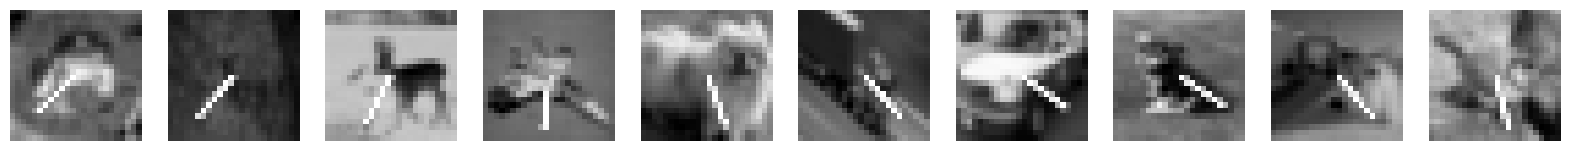

In [4]:
seq_idx = 0
num_imgs = 10

fig, ax = plt.subplots(1, num_imgs, figsize=(2 * num_imgs, 3))
for i in range(num_imgs):
    ax[i].imshow(data.train_obs[0][seq_idx, i*data.train_obs[0].shape[1]//num_imgs], cmap="gray")
    ax[i].set_axis_off()

In [5]:
### prior
latent_dim = 8

prior = dists.LGStationaryParam(
    start_from_invariant=True,
    stay_at_invariant=True,
    opt_params=["A"],
    A=0.5*np.eye(latent_dim)
)

In [6]:
### recognition
network = recognition.CNN([
    {"features": 32, "kernel_size": (3, 3), "strides": (1, 1) },
    {"features": 64, "kernel_size": (3, 3), "strides": (2, 2) },
    {"features": 32, "kernel_size": (3, 3), "strides": (2, 2) }
])
rec = [
    recognition.RPMRecognition(
        network=network,
        dist_map=distmaps.MVNDiag(latent_dim),
        constant_cov=False
    )
]

In [7]:
### model
model = rpm.RPSSM(
    prior=prior,
    recognition=rec
)

In [8]:
### training config
LR_SCHEDULE = optax.schedules.exponential_decay(1e-3, 5000, 0.2) # add some LR decay to stabilize training

cfg = config.Config(
    num_iter=5000,
    prior_lr=LR_SCHEDULE,
    rec_lr=(LR_SCHEDULE,),
    batch_size=32,
    jit=True,
    stabilize_A="clip", # clip singular values to 1-eps
    seed=SEED
)

In [9]:
### logger
def logger(trainer, aux, batch_indices):
    if trainer.itr % 50 == 0:
        posterior = aux["posterior"]
        R2 = [
            utils.linear_r2(posterior.params["means"], np.sin(data.train_states[batch_indices, :, 0, None]))[0],
            utils.linear_r2(posterior.params["means"], data.train_states[batch_indices, :, 1, None])[0]
        ]
        R2s = getattr(trainer, "R2s", [])
        R2s.append(R2)
        setattr(trainer, "R2s", R2s)
    return {"R2": f"{np.mean(np.array(trainer.R2s[-1])):.2f}"}

In [10]:
### free energy
free_energy = rpm.ConstrainedIVFreeEnergy(model=model)

In [11]:
### initialize and run trainer
trainer = training.Trainer(
    free_energy=free_energy,
    config=cfg,
    logger=logger
)
trainer.fit(data.train_data)

Training with N=500, T=100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:57<00:00, 16.82it/s, R2=0.77, loss=1.359]


Text(0.5, 1.0, '$R^2$')

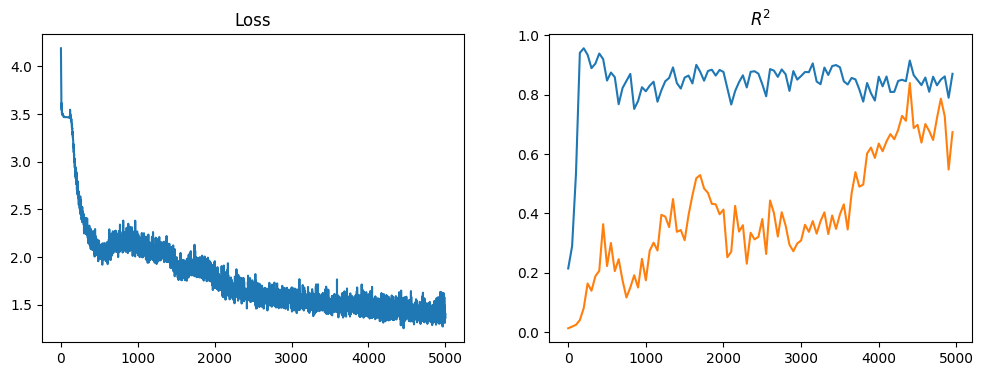

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(trainer.loss_tot)
ax[0].set_title("Loss")

ax[1].plot(np.arange(100)*50, trainer.R2s)
ax[1].set_title(r"$R^2$")

In [14]:
### refine over an additional 5K iterations
trainer.train_continue(data.train_data, 5000, jr.PRNGKey(42))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:48<00:00, 17.35it/s, R2=0.91, loss=1.409]


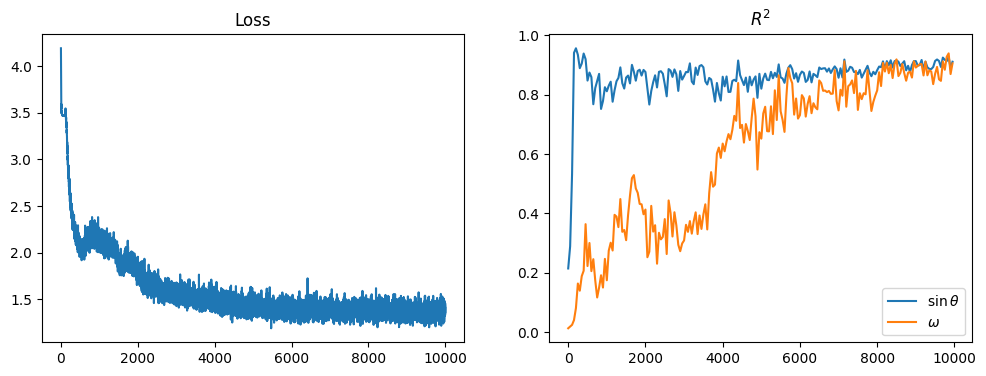

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(trainer.loss_tot)
ax[0].set_title("Loss")
ax[1].plot(np.arange(200)*50, trainer.R2s)
ax[1].set_title(r"$R^2$")
ax[1].legend([r"$\sin\theta$", r"$\omega$"])

In [16]:
### set up auxiliary generative model
generative_network = generation.GenerativeNetwork(
    network=generation.DCNN([
        {"features": 64, "kernel_size": (3, 3), "strides": (2, 2) },
        {"features": 32, "kernel_size": (3, 3), "strides": (2, 2) },
        {"features": 1, "kernel_size": (3, 3), "strides": (1, 1) }
    ], base_features=32),
    data_size=576,
    constant_cov=True,
    sigmoid=True
)

In [17]:
generative_model = generation.GenerativeModel(
    generative_network=generative_network
)

In [18]:
gen_cfg = config.GenerativeConfig(
    num_iter=10000,
    batch_size=4,
    seed=100,
    jit=True,
    num_samples=10,
    lr=1e-3
)

In [19]:
generative_trainer = training.GenerativeTrainer(
    generative_model=generative_model,
    trainer=trainer,
    config=gen_cfg
)

In [20]:
### train
generative_trainer.fit(data.train_data)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:00<00:00, 11.90it/s, loss=-46.651]


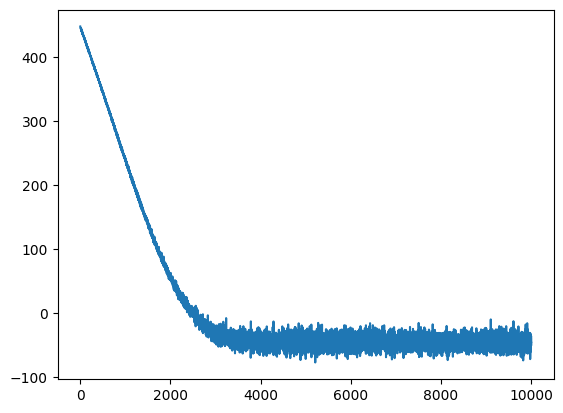

In [21]:
plt.plot(generative_trainer.loss_tot)

In [22]:
### reconstruct validation sequence
val_data = data.val_data[0]
rec = generative_trainer.reconstruct(val_data)

Text(-0.1, 0.025, 'Reconstructions')

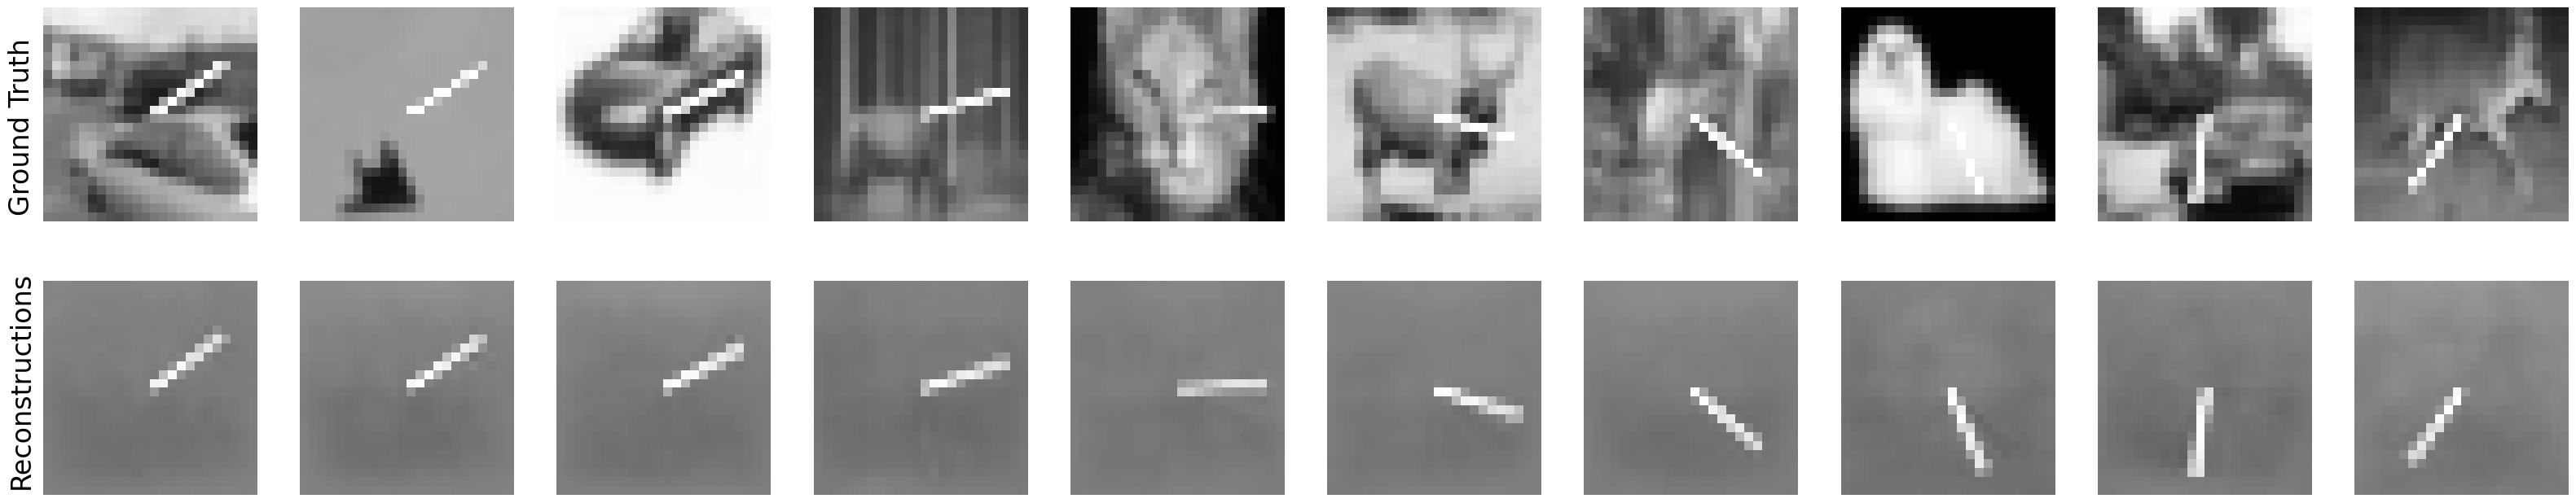

In [23]:
num_points = 10
fig, ax = plt.subplots(2, num_points, figsize=(num_points*4, 8))

for i in range(num_points):
    ax[0,i].imshow(val_data.obs[0][5*i], cmap="gray", vmin=0, vmax=1)
    ax[0,i].axis("off")
    ax[1,i].imshow(rec.params["mean"][5*i].reshape(val_data.obs[0][5*i].shape), cmap="gray", vmin=0, vmax=1)
    ax[1,i].axis("off")

ax[0,0].set_title("Ground Truth", rotation="vertical", x=-1/10, y=1/40, fontsize=24)
ax[1,0].set_title("Reconstructions", rotation="vertical", x=-1/10, y=1/40, fontsize=24)